<a href="https://colab.research.google.com/github/csernabalint/Thesis_Project_Workbook/blob/main/Szakdolgozat_Projektfeladat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Thesis Project Workbook**
###*Analysis of Pharmaceutical Dataset using Computer Vision Techniques*###
####*Dataset URL: https://www.kaggle.com/datasets/vencerlanz09/pharmaceutical-drugs-and-vitamins-synthetic-images*####
*Created by: Cserna Bálint (D183H1)*

##1. Import Kaggle API

In [3]:
!rm -rf '/content'

In [4]:
import os

# Check if the directory exists
if not os.path.exists('/content'):
    os.makedirs('/content')  # Create the directory
    print("Directory '/content' created.")
else:
    print("Directory '/content' already exists.")

# Change into the directory
os.chdir('/content')
print(f"Current working directory: {os.getcwd()}")

Directory '/content' created.
Current working directory: /content


In [5]:
import os
from getpass import getpass
import json

# Enter kaggle username securely
#kaggle_username = getpass('Kaggle username: ')
# Enter kaggle key securely
#kaggle_key = getpass('Kaggle key: ')

# Create the .kaggle directory
os.makedirs(os.path.expanduser('~/.kaggle'), exist_ok=True)

# Write the kaggle.json file securely
kaggle_json = {
    "username": 'blintcserna',
    "key": 'e15af8e11a06a70e64acc846179d97a6'
}
with open(os.path.expanduser('~/.kaggle/kaggle.json'), 'w') as file:
    json.dump(kaggle_json, file)

# Set permissions for the kaggle.json file
os.chmod(os.path.expanduser('~/.kaggle/kaggle.json'), 0o600)

# Verify that the file is in place (without showing contents)
!ls -l ~/.kaggle/kaggle.json

# Free up memory
#del file, kaggle_json, kaggle_key, kaggle_username

-rw------- 1 root root 70 Mar 12 11:52 /root/.kaggle/kaggle.json


##2. Load and Unzip Data

In [6]:
# Use Kaggle API to download
!kaggle datasets download -d vencerlanz09/pharmaceutical-drugs-and-vitamins-synthetic-images

Dataset URL: https://www.kaggle.com/datasets/vencerlanz09/pharmaceutical-drugs-and-vitamins-synthetic-images
License(s): CC-BY-SA-3.0
 98% 233M/238M [00:01<00:00, 200MB/s]
100% 238M/238M [00:01<00:00, 209MB/s]


In [7]:
#  Unzip the dataset
!unzip pharmaceutical-drugs-and-vitamins-synthetic-images.zip -d .

A streamkimeneten csak az utolsó 5000 sor látható.
  inflating: ./ImageClassesCombinedWithCOCOAnnotations/images_raw/00005001.jpg  
  inflating: ./ImageClassesCombinedWithCOCOAnnotations/images_raw/00005002.jpg  
  inflating: ./ImageClassesCombinedWithCOCOAnnotations/images_raw/00005003.jpg  
  inflating: ./ImageClassesCombinedWithCOCOAnnotations/images_raw/00005004.jpg  
  inflating: ./ImageClassesCombinedWithCOCOAnnotations/images_raw/00005005.jpg  
  inflating: ./ImageClassesCombinedWithCOCOAnnotations/images_raw/00005006.jpg  
  inflating: ./ImageClassesCombinedWithCOCOAnnotations/images_raw/00005007.jpg  
  inflating: ./ImageClassesCombinedWithCOCOAnnotations/images_raw/00005008.jpg  
  inflating: ./ImageClassesCombinedWithCOCOAnnotations/images_raw/00005009.jpg  
  inflating: ./ImageClassesCombinedWithCOCOAnnotations/images_raw/00005010.jpg  
  inflating: ./ImageClassesCombinedWithCOCOAnnotations/images_raw/00005011.jpg  
  inflating: ./ImageClassesCombinedWithCOCOAnnotations/ima

##3. Preprocess Data

###3.1. Import Libraries and Set Random Seed

In [8]:
# Import modules
import pandas as pd
import numpy as np
import csv
from PIL import Image
import json
import h5py
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import cv2
import glob
from sklearn.model_selection import train_test_split
import torch
#!pip install torchvision
import torchvision
from torchvision.datasets import CocoDetection
from torch.utils.data import DataLoader
# Initializing random seeds
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

###3.2. Load Images

####3.2.1. Define Folder Paths

####3.2.2. Load Single-Label Capsule Image Paths and their Labels

In [17]:
# Labels map
# labels : 'Neozep','Biogesic','Fishoil','Medicol','Bactidol','Bioflu','Kremil S','Alaxan','Decolgen','DayZinc'
capsule_label_map = {
    "Neozep" : 1,
    "Biogesic" : 2,
    "Fish Oil" : 3,
    "Medicol" : 4,
    "Bactidol" : 5,
    "Bioflu" : 6,
    "Kremil S" : 7,
    "Alaxan" : 8,
    "Decolgen" : 9,
    "DayZinc" : 10
}

In [18]:
# Inicialize lists for the picture paths and their labels
separate_synthetic_image_paths = []
separate_synthetic_image_labels = []

# Loop through folders using glob
for folder_capsules in glob.glob(os.path.join(separate_images_path, "*")):
  if os.path.isdir(folder_capsules): # If it is a folder than
    capsule_name = os.path.basename(folder_capsules) # Defining the label as the folder name
    images = glob.glob(os.path.join(folder_capsules, "*.jpg")) # Search for jpg. files

    for image in images:
      basename = os.path.basename(image)

      if "_single" in basename:
        print(f"File '{basename}' already has the new name. Breaking out of folder: {folder_capsules}")
        break
      id, ext = os.path.splitext(basename)
      new_basename = id + "_single" + ext

      new_path = image.replace(basename, new_basename)
      os.rename(image, new_path)


    # Select 500 random images from this folder
    images_single = glob.glob(os.path.join(folder_capsules, "*.jpg"))
    selected_images = random.sample(images_single, min(len(images), 500))
    separate_synthetic_image_paths.extend(selected_images) # Add images
    separate_synthetic_image_labels.extend([capsule_label_map[capsule_name]] * len(selected_images)) # Add labels

print("Number of images:", len(separate_synthetic_image_paths))
print("Number of labels:", len(separate_synthetic_image_labels))
print("First 10 images:", separate_synthetic_image_paths[:10])
print("First 10 labels:", separate_synthetic_image_labels[:10])

Number of images: 5000
Number of labels: 5000
First 10 images: ['/content/Drug Vision/Data Combined/Kremil S/00000141_single.jpg', '/content/Drug Vision/Data Combined/Kremil S/00000994_single.jpg', '/content/Drug Vision/Data Combined/Kremil S/00000949_single.jpg', '/content/Drug Vision/Data Combined/Kremil S/00000091_single.jpg', '/content/Drug Vision/Data Combined/Kremil S/00000958_single.jpg', '/content/Drug Vision/Data Combined/Kremil S/00000004_single.jpg', '/content/Drug Vision/Data Combined/Kremil S/00000505_single.jpg', '/content/Drug Vision/Data Combined/Kremil S/00000271_single.jpg', '/content/Drug Vision/Data Combined/Kremil S/00000553_single.jpg', '/content/Drug Vision/Data Combined/Kremil S/00000992_single.jpg']
First 10 labels: [7, 7, 7, 7, 7, 7, 7, 7, 7, 7]


####3.2.3. Load Multi-Label Capsule Image Paths and their Annotations

In [9]:
def normalize_bbox_and_format_input(bbox, image_width, image_height):
    x_min, y_min, width, height = bbox

    x_center = x_min + width / 2
    y_center = y_min + height / 2
    x_norm_center = x_center / image_width
    y_norm_center = y_center / image_height
    width_norm = width / image_width
    height_norm = height / image_height

    return [x_norm_center, y_norm_center, width_norm, height_norm]

In [10]:
# Defining the file path of folders
separate_images_path = "/content/Drug Vision/Data Combined"
coco_path = "/content/ImageClassesCombinedWithCOCOAnnotations"

# Load coco image paths
images_raw_dir = os.path.join(coco_path, "images_raw")
coco_image_paths = glob.glob(os.path.join(images_raw_dir, "*.jpg"))

# Get coco data from json file
coco_json_path = os.path.join(coco_path, "coco_instances.json")
with open(coco_json_path, "r") as f:
    coco_data = json.load(f)

In [11]:
# Process coco structure for YOLO

  # Load images info metadata
images_info = {img["id"]: img for img in coco_data["images"]}

  # Load information of single/multi -label images from json
coco_labels = {}
for ann in coco_data["annotations"]:
    if ann["iscrowd"] == 1: # If crowd then skip
      continue

    image_id = ann["image_id"]
    file_name = images_info[image_id]["file_name"]
    width = images_info[image_id]["width"]
    height = images_info[image_id]["height"]
    normalized_bbox = normalize_bbox_and_format_input(ann["bbox"], width, height)
    # Create annotation dict
    annotation = { 'category_id': ann['category_id'] -1, 'bbox': normalized_bbox}

    # Add
    if file_name in coco_labels:
      coco_labels[file_name].append(annotation)
    else:
      coco_labels[file_name] = [annotation]

# Create a dictionary for the dataset
coco_dataset = {}
for img_path in coco_image_paths:
    file_name = os.path.basename(img_path)
    # Get the annotations of the file_name from coco_labels
    labels = coco_labels.get(file_name, [])
    coco_dataset[img_path] = {
        "annotations": labels
    }


print("Number of images:", len(coco_dataset))
# Print the first 10 items in the dictionary
for i, (key, value) in enumerate(coco_dataset.items()):
    print(f"{key}: {value}")
    if i >= 9:  # Limit to first 10 items
        break

Number of images: 10000
/content/ImageClassesCombinedWithCOCOAnnotations/images_raw/00009074.jpg: {'annotations': [{'category_id': 0, 'bbox': [0.805, 0.545, 0.07333333333333333, 0.1]}, {'category_id': 4, 'bbox': [0.39166666666666666, 0.43666666666666665, 0.07333333333333333, 0.06333333333333334]}]}
/content/ImageClassesCombinedWithCOCOAnnotations/images_raw/00005065.jpg: {'annotations': [{'category_id': 6, 'bbox': [0.6583333333333333, 0.6016666666666667, 0.09333333333333334, 0.11333333333333333]}, {'category_id': 3, 'bbox': [0.5583333333333333, 0.5416666666666666, 0.06, 0.06666666666666667]}]}
/content/ImageClassesCombinedWithCOCOAnnotations/images_raw/00003783.jpg: {'annotations': [{'category_id': 9, 'bbox': [0.365, 0.5483333333333333, 0.2, 0.23333333333333334]}, {'category_id': 8, 'bbox': [0.7433333333333333, 0.44, 0.07666666666666666, 0.09666666666666666]}, {'category_id': 6, 'bbox': [0.535, 0.4083333333333333, 0.07333333333333333, 0.07333333333333333]}]}
/content/ImageClassesCombin

###3.3. Train-Valdiation-Test Split

In [12]:
# Train-val-test split
coco_paths = list(coco_dataset.keys())
coco_labels_list = list(coco_dataset.values())


# Perform the split
coco_train_keys, coco_temp_keys, coco_train_labels, coco_temp_labels = train_test_split(
    coco_paths, coco_labels_list, test_size=0.2, random_state=42
)

coco_val_keys, coco_test_keys, coco_val_labels, coco_test_labels = train_test_split(
    coco_temp_keys, coco_temp_labels, test_size=0.5, random_state=42
)

# Mapping keys back to data
coco_train = {key: coco_dataset[key] for key in coco_train_keys}
coco_val = {key: coco_dataset[key] for key in coco_val_keys}
coco_test = {key: coco_dataset[key] for key in coco_test_keys}

print("COCO data:")
print("  Training:", len(coco_train_keys), "labels:", len(coco_train_labels))
print("  Validation:", len(coco_val_keys), "labels:", len(coco_val_labels))
print("  Test:", len(coco_test_keys), "labels:", len(coco_test_labels))

COCO data:
  Training: 8000 labels: 8000
  Validation: 1000 labels: 1000
  Test: 1000 labels: 1000


In [13]:
def resize_and_save_with_progress(image_paths, image_output_dir, label_paths, label_output_dir):
    os.makedirs(image_output_dir, exist_ok=True)
    os.makedirs(label_output_dir, exist_ok=True)

    total_images = len(image_paths)
    errors = 0

    for idx, image_path in enumerate(image_paths):
        try:

            # Check if the labels file already exists
            labels_file_path = os.path.join(label_output_dir, os.path.basename(image_path).replace(".jpg", ".txt"))
            if not os.path.exists(labels_file_path):
                # Create the labels file
              with open(labels_file_path, "w") as f:
                    for i in label_paths[idx]['annotations']:
                      a, b , c ,d =  i['bbox']
                      l = f"{i['category_id']} {a} {b} {c} {d}"
                      f.write(f"{l}\n")

            # Read the image
            image = cv2.imread(image_path)

            if image is None:
                print(f"Error: Unable to read image: {image_path}")
                errors += 1
                continue

            # Apply INTER_CUBIC interpolation without resizing
            processed_image = cv2.resize(image, dsize=(image.shape[1], image.shape[0]), interpolation=cv2.INTER_CUBIC)

            # Define the output path
            base_name = os.path.basename(image_path)
            output_path = os.path.join(image_output_dir, base_name)
            # Save the resized image
            cv2.imwrite(output_path, processed_image)

            # Print progress
            if (idx + 1) % 100 == 0 or idx == total_images - 1:
                print(f"Processed {idx + 1}/{total_images} images.")

        except Exception as e:
            print(f"Error processing image: {image_path}. Details: {e}")
            errors += 1

    print(f"\nProcessing complete. {total_images - errors}/{total_images} images resized successfully.")
    if errors > 0:
        print(f"Encountered {errors} errors during processing.")


In [14]:
# Define output directories for each set
train_output_dir = "/content//Resized_Images/resized_train/images"
val_output_dir   = "/content/Resized_Images/resized_val/images"
test_output_dir  = "/content/Resized_Images/resized_test/images"
train_output_dir_labels = "/content/Resized_Images/resized_train/labels"
val_output_dir_labels   = "/content/Resized_Images/resized_val/labels"
test_output_dir_labels  = "/content/Resized_Images/resized_test/labels"
# Process training images
resize_and_save_with_progress(coco_train_keys, train_output_dir, coco_train_labels, train_output_dir_labels)

# Process validation images
resize_and_save_with_progress(coco_val_keys, val_output_dir, coco_val_labels, val_output_dir_labels)

# Process testing images
resize_and_save_with_progress(coco_test_keys, test_output_dir, coco_test_labels, test_output_dir_labels)

Processed 100/8000 images.
Processed 200/8000 images.
Processed 300/8000 images.
Processed 400/8000 images.
Processed 500/8000 images.
Processed 600/8000 images.
Processed 700/8000 images.
Processed 800/8000 images.
Processed 900/8000 images.
Processed 1000/8000 images.
Processed 1100/8000 images.
Processed 1200/8000 images.
Processed 1300/8000 images.
Processed 1400/8000 images.
Processed 1500/8000 images.
Processed 1600/8000 images.
Processed 1700/8000 images.
Processed 1800/8000 images.
Processed 1900/8000 images.
Processed 2000/8000 images.
Processed 2100/8000 images.
Processed 2200/8000 images.
Processed 2300/8000 images.
Processed 2400/8000 images.
Processed 2500/8000 images.
Processed 2600/8000 images.
Processed 2700/8000 images.
Processed 2800/8000 images.
Processed 2900/8000 images.
Processed 3000/8000 images.
Processed 3100/8000 images.
Processed 3200/8000 images.
Processed 3300/8000 images.
Processed 3400/8000 images.
Processed 3500/8000 images.
Processed 3600/8000 images.
P

In [15]:
valid_paths = [path for path in coco_train if os.path.isfile(path)]
print(f"Number of valid paths: {len(valid_paths)}")
print(f"Number of invalid paths: {len(coco_train) - len(valid_paths)}")


Number of valid paths: 8000
Number of invalid paths: 0


###3.4. Define Subdirectories and Save Images

In [17]:
# Define yaml file
yaml_content = """
train: /content/Resized_Images/resized_train
val: /content/Resized_Images/resized_val

nc: 10
names: ['Neozep','Biogesic','Fish Oil','Medicol','Bactidol','Bioflu','Kremil S','Alaxan','Decolgen','DayZinc']
"""

# Create and save the file
with open("filename.yaml", "w") as file:
    file.write(yaml_content)

In [18]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 932.9/932.9 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 116.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 98.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [2]:

from ultralytics import YOLO

model = YOLO("yolo11n.pt")

results = model.train(data ="filename.yaml", epochs=30, imgsz = 300, batch = 64)

Ultralytics 8.3.88 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=filename.yaml, epochs=30, time=None, patience=100, batch=64, imgsz=300, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxe

train: Scanning /content/Resized_Images/resized_train/labels... 8000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 8000/8000 [00:05<00:00, 1467.96it/s]


train: New cache created: /content/Resized_Images/resized_train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/Resized_Images/resized_val/labels... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<00:00, 1363.31it/s]

val: New cache created: /content/Resized_Images/resized_val/labels.cache


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 320 train, 320 val
Using 8 dataloader workers
Logging results to runs/detect/train2
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.35G      1.122      2.849     0.9372        193        320: 100%|██████████| 125/125 [00:17<00:00,  7.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.92it/s]

                   all       1000       1989      0.909      0.744       0.89      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.66G      1.001      1.089     0.9321        176        320: 100%|██████████| 125/125 [00:16<00:00,  7.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.54it/s]

                   all       1000       1989      0.933      0.892      0.954      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.66G     0.9888     0.9332      0.938        183        320: 100%|██████████| 125/125 [00:16<00:00,  7.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.60it/s]

                   all       1000       1989      0.954      0.949      0.973      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.66G     0.9719     0.8295     0.9433        177        320: 100%|██████████| 125/125 [00:16<00:00,  7.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.59it/s]

                   all       1000       1989      0.932      0.928      0.972      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.66G     0.9377     0.7595     0.9313        181        320: 100%|██████████| 125/125 [00:16<00:00,  7.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.65it/s]

                   all       1000       1989      0.973      0.945       0.98      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.66G     0.9324     0.7175     0.9309        178        320: 100%|██████████| 125/125 [00:16<00:00,  7.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.62it/s]

                   all       1000       1989      0.956      0.952      0.978      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.66G     0.9203     0.6845     0.9278        199        320: 100%|██████████| 125/125 [00:16<00:00,  7.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.64it/s]

                   all       1000       1989      0.976      0.958      0.982      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.66G     0.8978     0.6606     0.9232        192        320: 100%|██████████| 125/125 [00:16<00:00,  7.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.62it/s]

                   all       1000       1989      0.977      0.962      0.985      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.66G      0.884     0.6355     0.9171        161        320: 100%|██████████| 125/125 [00:16<00:00,  7.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.69it/s]

                   all       1000       1989      0.973      0.966      0.986      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.66G     0.8756     0.6279     0.9148        185        320: 100%|██████████| 125/125 [00:16<00:00,  7.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.63it/s]

                   all       1000       1989      0.975      0.961      0.986      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.66G     0.8622     0.6069     0.9065        193        320: 100%|██████████| 125/125 [00:16<00:00,  7.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.70it/s]

                   all       1000       1989      0.971      0.961      0.984      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.66G     0.8469     0.5617     0.9017        200        320: 100%|██████████| 125/125 [00:16<00:00,  7.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.66it/s]

                   all       1000       1989      0.974      0.963      0.985      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.66G     0.8005     0.5131     0.8941        197        320: 100%|██████████| 125/125 [00:16<00:00,  7.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.60it/s]

                   all       1000       1989      0.982      0.965      0.987      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.66G     0.7713     0.4899     0.8848        207        320: 100%|██████████| 125/125 [00:16<00:00,  7.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.65it/s]

                   all       1000       1989      0.982      0.968      0.986      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.66G     0.7336     0.4724     0.8789        159        320: 100%|██████████| 125/125 [00:16<00:00,  7.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.64it/s]

                   all       1000       1989      0.988      0.971      0.987      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.66G     0.7166     0.4575     0.8768        165        320: 100%|██████████| 125/125 [00:16<00:00,  7.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.62it/s]

                   all       1000       1989      0.989      0.969      0.989      0.863



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.66G     0.6967     0.4422     0.8733        214        320: 100%|██████████| 125/125 [00:16<00:00,  7.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.67it/s]

                   all       1000       1989      0.985      0.962      0.986      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.66G     0.6852     0.4402     0.8686        197        320: 100%|██████████| 125/125 [00:16<00:00,  7.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.66it/s]

                   all       1000       1989      0.994      0.969      0.988      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.66G     0.6663     0.4262     0.8689        177        320: 100%|██████████| 125/125 [00:16<00:00,  7.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.68it/s]

                   all       1000       1989      0.991      0.968      0.987      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.66G     0.6482     0.4157     0.8627        189        320: 100%|██████████| 125/125 [00:16<00:00,  7.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.65it/s]

                   all       1000       1989      0.988      0.973       0.99      0.828


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.66G     0.7141     0.4085     0.8615        129        320: 100%|██████████| 125/125 [00:17<00:00,  7.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.63it/s]

                   all       1000       1989       0.99      0.969      0.989      0.854



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.66G     0.6925     0.4012     0.8565        126        320: 100%|██████████| 125/125 [00:16<00:00,  7.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.64it/s]

                   all       1000       1989      0.988      0.971      0.989      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.66G     0.6703      0.396     0.8502        124        320: 100%|██████████| 125/125 [00:16<00:00,  7.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.61it/s]

                   all       1000       1989      0.991      0.974       0.99       0.84



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.66G      0.658     0.3926     0.8498        127        320: 100%|██████████| 125/125 [00:16<00:00,  7.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.69it/s]

                   all       1000       1989      0.983      0.977       0.99      0.849



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.66G     0.6462     0.3856     0.8451        117        320: 100%|██████████| 125/125 [00:16<00:00,  7.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.65it/s]

                   all       1000       1989      0.985      0.974      0.989      0.846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.66G     0.6372     0.3817     0.8438        114        320: 100%|██████████| 125/125 [00:16<00:00,  7.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.66it/s]

                   all       1000       1989      0.992      0.977       0.99      0.851



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.66G     0.6223     0.3781     0.8391        124        320: 100%|██████████| 125/125 [00:16<00:00,  7.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.63it/s]

                   all       1000       1989       0.99      0.977       0.99      0.868



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.66G     0.6103     0.3678      0.837        135        320: 100%|██████████| 125/125 [00:16<00:00,  7.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.66it/s]

                   all       1000       1989      0.989      0.977       0.99      0.862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.66G     0.5976     0.3599     0.8342        135        320: 100%|██████████| 125/125 [00:16<00:00,  7.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.67it/s]

                   all       1000       1989      0.988      0.978       0.99       0.87



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.66G     0.5889       0.36     0.8307        122        320: 100%|██████████| 125/125 [00:16<00:00,  7.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.64it/s]

                   all       1000       1989      0.988      0.977      0.991      0.867



30 epochs completed in 0.169 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 5.4MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 5.4MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics 8.3.88 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11n summary (fused): 100 layers, 2,584,102 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.83it/s]


                   all       1000       1989      0.989      0.978       0.99       0.87
                Neozep        182        196      0.984       0.96      0.987      0.866
              Biogesic        194        203      0.991       0.97      0.986      0.841
              Fish Oil        184        205      0.978       0.98      0.994      0.878
               Medicol        169        181      0.997      0.989      0.995      0.896
              Bactidol        175        185      0.994      0.978      0.993      0.854
                Bioflu        187        193      0.992      0.995      0.995       0.91
              Kremil S        198        211      0.992      0.991      0.994      0.879
                Alaxan        200        214      0.976      0.953      0.982      0.805
              Decolgen        192        208      0.998      0.981       0.99      0.889
               DayZinc        184        193      0.987      0.984      0.988      0.881
Speed: 0.0ms preproce

In [24]:
import os

# Force UTF-8 encoding
os.environ["PYTHONIOENCODING"] = "UTF-8"
os.environ["LC_ALL"] = "C.UTF-8"
os.environ["LANG"] = "C.UTF-8"


In [25]:
import locale
print(locale.getpreferredencoding())


ANSI_X3.4-1968


In [ ]:
from IPython.display import Image
from image_path in glob.glob(f"/content/runs/detect/predict/"*.jpg)

###3.7. Define Dataset Class

###3.8. Data Normalization

Number of images in folder: 3
Average image dimensions: 1408.0 x 1408.0 pixels
Average file size: 250.9 KB


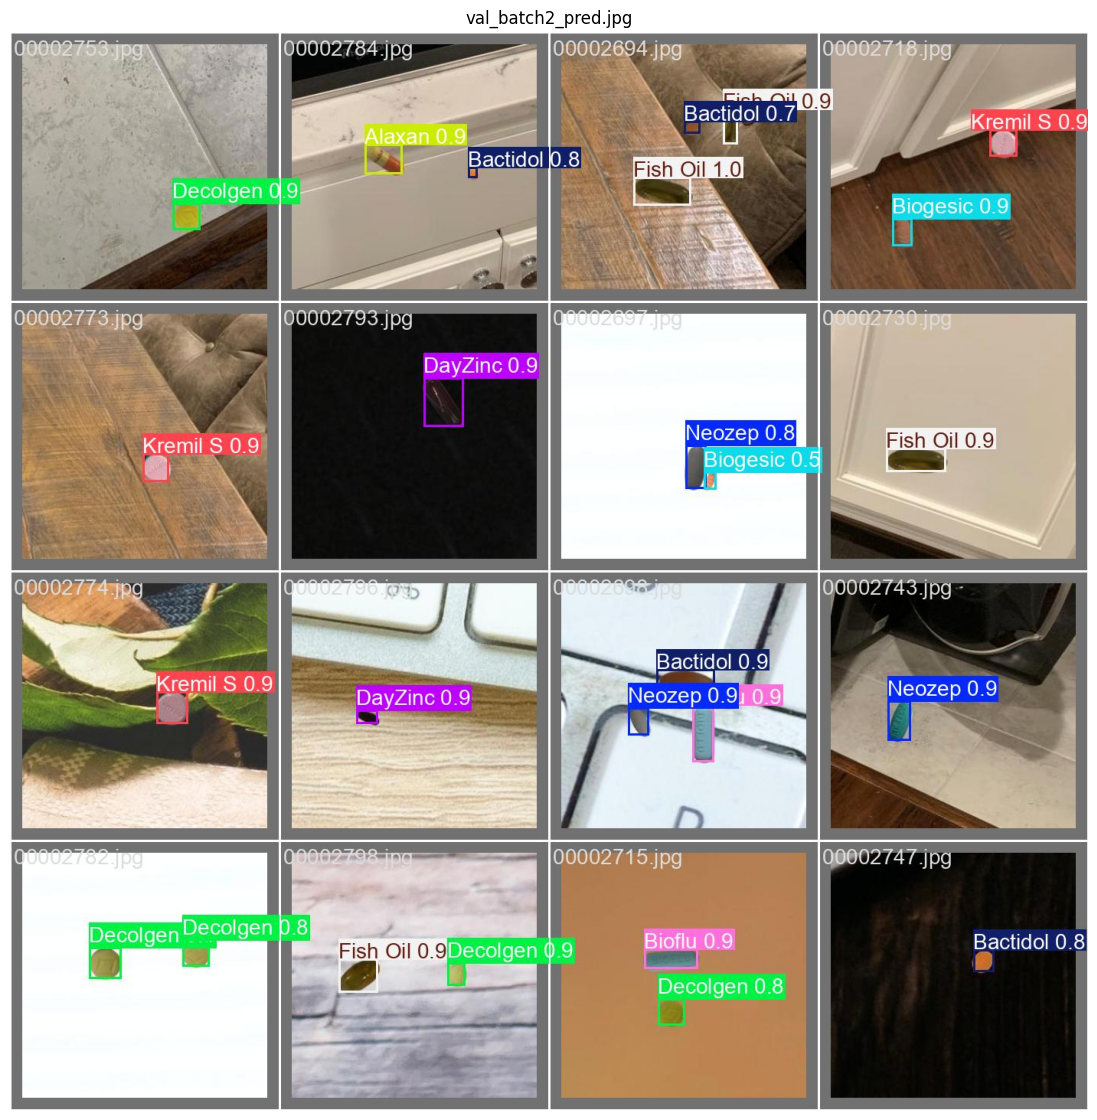

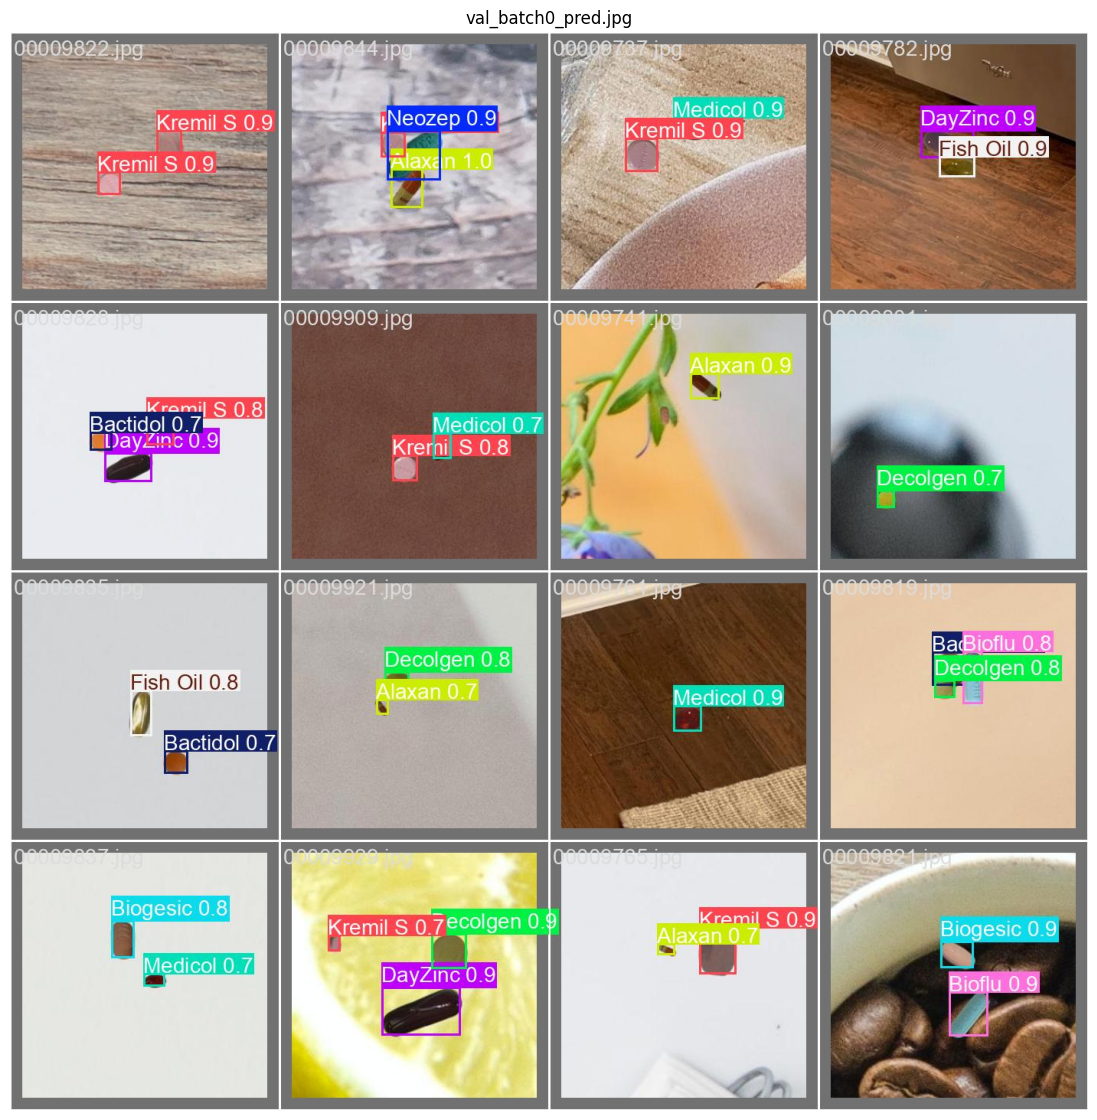

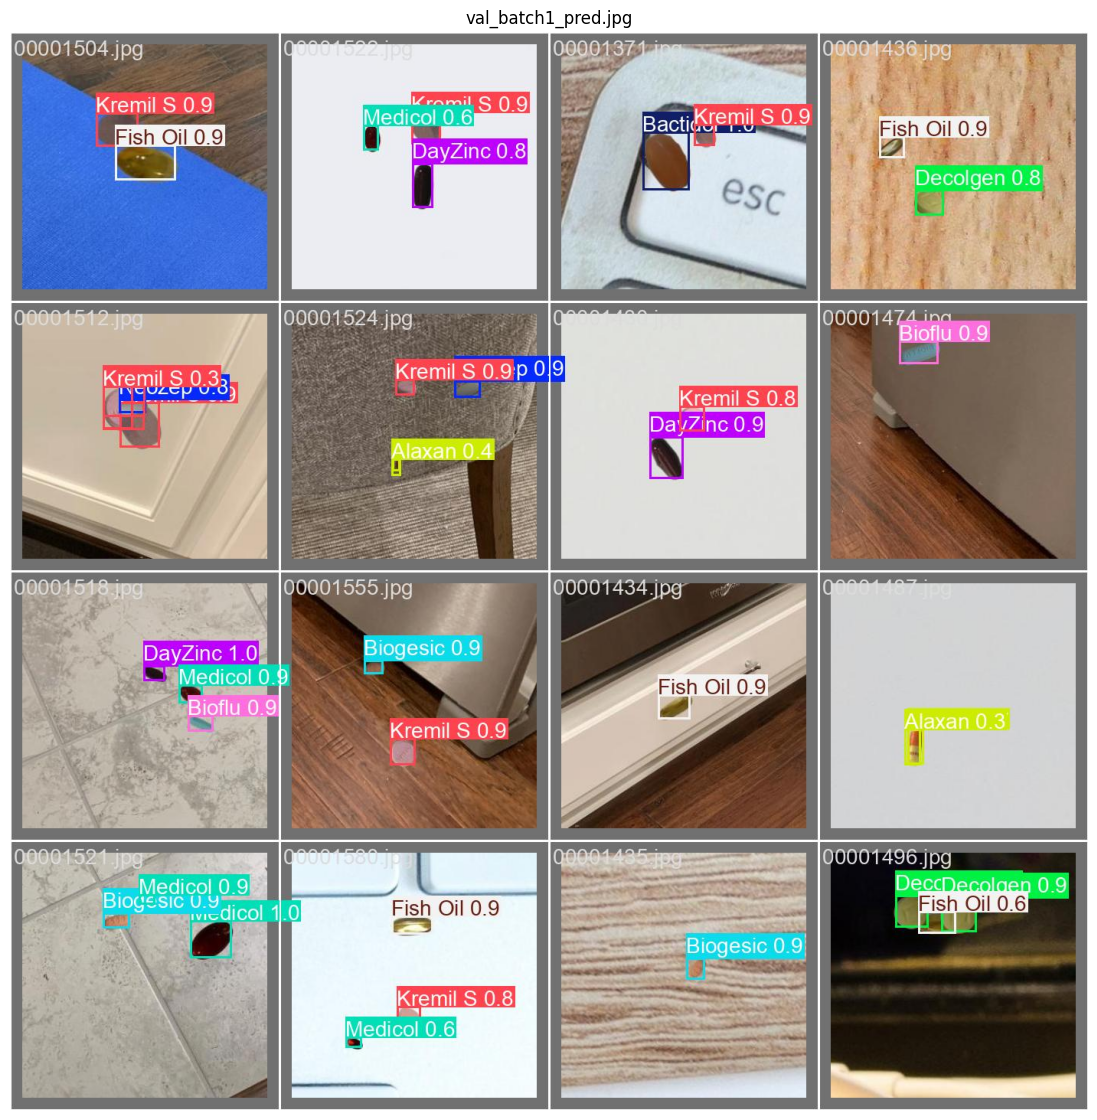

In [43]:
import os
import glob
import cv2
import matplotlib.pyplot as plt

# Define the folder path (adjust if needed)
folder_path = "/content/runs/detect/train2"

# Get all jpg image paths in the folder
image_paths = glob.glob(os.path.join(folder_path, "*_pred.jpg"))
# Print the number of images
num_images = len(image_paths)
print("Number of images in folder:", num_images)

# Initialize lists to store image dimensions and file sizes
widths = []
heights = []
file_sizes = []

# Loop through the images to collect statistics
for path in image_paths:
    # Read image using OpenCV (BGR format)
    img = cv2.imread(path)
    if img is not None:
        h, w = img.shape[:2]
        widths.append(w)
        heights.append(h)
    # Get file size in bytes
    file_sizes.append(os.path.getsize(path))

# Calculate and print average dimensions if available
if widths and heights:
    avg_width = sum(widths) / len(widths)
    avg_height = sum(heights) / len(heights)
    print(f"Average image dimensions: {avg_width:.1f} x {avg_height:.1f} pixels")

# Calculate and print average file size in KB if available
if file_sizes:
    avg_size_kb = sum(file_sizes) / len(file_sizes) / 1024
    print(f"Average file size: {avg_size_kb:.1f} KB")

# Display a few images
num_to_display = 5
for i in range(min(num_to_display, num_images)):
    img = cv2.imread(image_paths[i])
    if img is not None:
        # Convert from BGR to RGB for proper display using matplotlib
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(14, 14))
        plt.imshow(img_rgb)
        plt.title(os.path.basename(image_paths[i]))
        plt.axis('off')
        plt.show()


##4. Load Models (YOLOv5/YOLOv8;SSD;Faster R-CNN)

In [2]:
import cv2
import matplotlib.pyplot as plt

test_image_path = "/content/ImageClassesCombinedWithCOCOAnnotations/test_image.JPG"
cv2.imread(test_image_path)

plt.figure(figsize=(14, 14))
plt.imshow(img)
plt.show()

NameError: name 'img' is not defined

<Figure size 1400x1400 with 0 Axes>

##5. Define Hyperparameters

##6. Create the Training and Validation functions

##7. Run the Model

##8. Sample Evaluation

##9. Plot Training and Validation Loss and Accuracy

##9. Evaluatiuon

###9.1. Evaluation with Confusion Matrix an Other Metrics

###9.2. Evaluation with the Roc-AUC Curve